# MODELING
Train a model to classify waterpoint functionality. Ternary classification: 'functional', 'non-functional', and 'functional needs repair'. There is a significant class imbalance. Data was cleaned and missing value imputed, please see [cleaning notebook](./data_cleaning.ipynb) for resoning. Validation data was cleaned/imputed in the same way [here](./validation_transformation.ipynb). Will try the following classifiers: Random Forest, Bagged Tree, Gradient Boosted, and XG Boosted.

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import xgboost as xgb

np.random.seed(619)

In [2]:
def print_accuracy(model, X_train, y_train, X_test, y_test, cm=False, get_y_hat=False):
    """ X's should be preprocessed identically.
        Confusion matrix: rows = TRUE, columns = predicted, 
        top L diagonal down to bottom R are TRUE-POSITIVE.
        TRUE-NEG: a 0 outside the TP diagonal.
        False-Pos: column of an item that is not in True row (falsely pred as item).
        False-Neg: row of an item that is not in Pred colum (falsey pred as NOT item)"""
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    acc_test = round(accuracy_score(y_test, y_pred_test),3) * 100
    acc_train = round(accuracy_score(y_train, y_pred_train),3) * 100
    print(f'Test accuracy: {acc_test} %')
    print(f'Train accuracy: {acc_train} %')
    if cm == True:
        print(confusion_matrix(y_test, y_pred_test))
    if get_y_hat == True:
        return y_pred_test

def plot_confusion(model, X_test, y_test, normalize=None, form='.2f'):
    """ normalize{‘true’, ‘pred’, ‘all’}, default=None
        Normalizes over the true (rows), predicted (columns) conditions or all the population. 
        If None, confusion matrix will not be normalized."""
    plot_confusion_matrix(model, X_test, y_test, 
                          cmap=plt.cm.Blues, xticks_rotation='vertical',
                          normalize=normalize, values_format=form)
    plt.show()
    
def plot_feature_importance(model, ohencoder, X_encoder_input, num_features=25):
    top_features_list = []
    for item in zip(ohencoder.get_feature_names(X_encoder_input.columns), model.feature_importances_):
        if item[1] > 0:
            top_features_list.append(item)
    top_feats = sorted(top_features_list, key=lambda x: x[1], reverse=True)
    x_feats_importance = list(map(lambda x: x[1], top_feats[:num_features]))
    y_feats_labels = list(map(lambda x: x[0], top_feats[:num_features]))
    fig, ax = plt.subplots(figsize=(10,10))
    plt.barh(y_feats_labels, x_feats_importance, align='center')
    ax.set_yticks(y_feats_labels)
    ax.set_yticklabels(y_feats_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Importance')
    ax.set_ylabel('Features')
    ax.set_title(f'Top {num_features} Features Ranked by Importance')
    plt.show()

def get_mean_cross_val(model, full_train_df, target, cv=5):
    """Pass in the entire training dataset, as well as all of the labels"""
    return f"Cross-Val Score (k=5):'{cross_val_score(model, full_train_df, target, cv=cv).mean()}"

def print_GS_results(gridSearch, df=False):
    if df == True:
        display(pd.DataFrame(gridSearch.cv_results_))
    print("Best Score:", gridSearch.best_score_)
    return gridSearch.best_params_

In [3]:
# import cleaned training data as the modeling set
df_train = pd.read_csv("../data/cleaned_train_df.csv", index_col='id')
display(df_train.head())
df_train.info()

,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,...,management,payment,water_quality,quantity,source,waterpoint_type,status_group,year_rec,month_rec,age
id,,,,,,,,,,,,,,,,,,,,,
69572,1390,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,other,109,True,...,vwc,pay annually,soft,enough,spring,communal standpipe,functional,2011,3,12
8776,1399,34.698766,-2.147466,Lake Victoria,Mara,20,2,other,280,False,...,wug,never pay,soft,insufficient,rainwater harvesting,communal standpipe,functional,2013,3,3
34310,686,37.460664,-3.821329,Pangani,Manyara,21,4,other,250,True,...,vwc,pay per bucket,soft,enough,dam,communal standpipe multiple,functional,2013,2,4
67743,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,other,58,True,...,vwc,never pay,soft,dry,machine dbh,communal standpipe multiple,non functional,2013,1,27
19728,743,31.130847,-1.825359,Lake Victoria,Kagera,18,1,other,182,True,...,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe,functional,2011,7,-1


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 69572 to 26348
Data columns (total 24 columns):
gps_height               59400 non-null int64
longitude                59400 non-null float64
latitude                 59400 non-null float64
basin                    59400 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
population               59400 non-null int64
public_meeting           59400 non-null bool
scheme_management        59400 non-null object
permit                   59400 non-null bool
construction_year        59400 non-null int64
extraction_type_group    59400 non-null object
management               59400 non-null object
payment                  59400 non-null object
water_quality            59400 non-null object
quantity                 59400 non-null object
source                   59400 non-null object
w

In [4]:
# seperate target from predictors, examine target distribution
y = df_train['status_group']
X = df_train.drop(columns = 'status_group')
y.value_counts(normalize=True)

functional                 0.543081
non functional             0.384242
functional needs repair    0.072677
Name: status_group, dtype: float64

In [5]:
# define numeric and categorical columns
numeric = list(X.select_dtypes(np.number).columns)
categorical = list(X.select_dtypes('object').columns)

In [6]:
# divide the modeling set into a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state=7)

#### Preprocessing

In [7]:
# typically scale numeric, but for the models selected to try it is not necessary
# encoded the categorical columns
ohe = OneHotEncoder(handle_unknown = 'ignore')
ohe.fit(X_train)
X_train_encoded = ohe.transform(X_train)
X_test_encoded = ohe.transform(X_test)

## Random Forest
#### Baseline Model

In [43]:
base_forest = RandomForestClassifier(verbose=2)
base_forest.fit(X_train_encoded, y_train)

RandomForestClassifier()

In [47]:
print_accuracy(base_forest, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 78.7 %
Train accuracy: 99.9 %
[[4385   71  378]
 [ 372  159  116]
 [ 939   23 2467]]


Quite significant overfitting. No max depth was set so the forest attempted to classify every point. Let's reign it in with some pruning.

#### Parameter Tuning to Find Best Model

In [ ]:
# forest = RandomForestClassifier(verbose=2)

# forest_param_grid = {"n_estimators" : [10, 50, 100],
#                 'criterion' : ['gini', 'entropy'],
#                 'max_depth' : [4, 6, 10],
#                 'min_samples_split' : [5, 10],
#                 'min_samples_leaf' : [3, 6]
#                 }

# gs_forest = GridSearchCV(estimator=forest, param_grid=forest_param_grid, 
#                          scoring='accuracy', cv=3, 
#                          verbose=2, n_jobs=-1)
# gs_forest.fit(X_train_encoded, y_train)

In [ ]:
# view gridSearch results

## Gradient Boost
#### Baseline Model

In [49]:
base_gbt = GradientBoostingClassifier(max_depth=4, verbose=1)
base_gbt.fit(X_train_encoded, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8501            5.89m
         2           0.8206            4.02m
         3           0.7974            3.30m
         4           0.7783            2.85m
         5           0.7626            2.53m
         6           0.7497            2.32m
         7           0.7385            2.17m
         8           0.7285            2.06m
         9           0.7198            1.97m
        10           0.7118            1.90m
        20           0.6620            1.57m
        30           0.6359            1.36m
        40           0.6186            1.15m
        50           0.6063           57.62s
        60           0.5966           45.64s
        70           0.5884           34.01s
        80           0.5815           22.64s
        90           0.5754           11.28s
       100           0.5703            0.00s


GradientBoostingClassifier(max_depth=4, verbose=1)

In [50]:
print_accuracy(base_gbt, X_train_encoded, y_train, X_test_encoded, y_test, cm = True)

Test accuracy: 75.7 %
Train accuracy: 76.4 %
[[4510   33  291]
 [ 452   89  106]
 [1268   17 2144]]


#### Parameter Tuning to Find Best Model

In [ ]:
gbt = GradientBoostingClassifier(verbose=2, max_depth = 3, n_estimators = 400, learning_rate =0.1)

gbt.fit(X_train_encoded, y_train)

#### Fit Best Model/Analysis


In [18]:
# classification_report, accuracy_score
print_accuracy(gbt, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 76.1 %
Train accuracy: 76.9 %
[[4470   27  337]
 [ 452   77  118]
 [1174   19 2236]]


## XG Boost
#### Baseline Model

In [30]:
base_xgbt = xgb.XGBClassifier(verbosity=1)
base_xgbt.fit(X_train_encoded, y_train)

XGBClassifier(objective='multi:softprob')

In [32]:
print_accuracy(base_xgbt, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 73.6 %
Train accuracy: 74.2 %


#### Parameter Tuning to Find Best Model

In [ ]:
xgbt = xgb.XGBClassifier(verbosity=2)

xg_param_grid = {
                'max_depth': [7, 9],
                'n_estimators': [200, 300],
                }

xgbt_gs = GridSearchCV(xgbt, xg_param_grid, scoring='accuracy', cv=3)
xgbt_gs.fit(X_train_encoded, y_train)

In [21]:
xgbt_best_params = xgbt_gs.best_params_
xgbt_best_params

{'max_depth': 9, 'n_estimators': 300}

In [25]:
xgbt_gs.best_score_


0.7834224598930483

In [26]:
xgbt_gs.best_estimator_

XGBClassifier(max_depth=9, n_estimators=300, objective='multi:softprob',
              verbosity=2)

In [27]:
print_accuracy(xgbt_gs, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 78.60000000000001 %
Train accuracy: 82.89999999999999 %
[[4451   59  324]
 [ 396  149  102]
 [1002   26 2401]]


In [ ]:
xgbt_gs_model= xgb.XGBClassifier(xgbt_best_params)
xgbt_gs_model.fit(X_train_encoded, y_train)

In [ ]:
print_accuracy(xgbt_gs_model, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

#### Fit Best Model/Analysis

In [58]:
# fit best grid search
best_xgbt = xgb.XGBClassifier(verbosity=1,learning_rate=0.2, max_depth=6, min_child_weight=2,n_estimators=100, subsample=0.7)
best_xgbt.fit(X_train_encoded, y_train)

XGBClassifier(learning_rate=0.2, max_depth=6, min_child_weight=2,
              objective='multi:softprob', subsample=0.7)

In [60]:
# predict and score
print_accuracy(best_xgbt, X_train_encoded, y_train, X_test_encoded, y_test, cm=True)

Test accuracy: 78.10000000000001 %
Train accuracy: 79.60000000000001 %
[[4465   46  323]
 [ 407  137  103]
 [1053   21 2355]]


A 4.5% increase in test accuracy from baseline XGBT!

## Class Imbalance
The two main classes are imbalanced and the third class is rare. I originally experimented with down sampling the majority classes and up sampling the minorities and reduced accuracy to around 70% for those trials. Third attempt will use SMOTE to generate artificial data to balance the classes.

In [76]:
# smote training set
smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_sample(X_train_encoded, y_train)
pd.Series(y_train_resampled).value_counts()

functional needs repair    27425
functional                 27425
non functional             19395
Name: status_group, dtype: int64

In [121]:
# fit to best forest params
forest_smote = RandomForestClassifier()
forest_smote.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier()

In [122]:
# predict with forest above
print_accuracy(forest_smote, X_train_resampled, y_train_resampled, X_test_encoded, y_test, cm=True)

Test accuracy: 78.5 %
Train accuracy: 99.9 %
[[4339  103  392]
 [ 360  176  111]
 [ 913   34 2482]]


This is almost the exact same as the unbalanced, baseline forest. Balancing did not improve performance. Model is still overfitting.

In [ ]:
# fit to best XG params
xgbt_smote = xgb.XGBClassifier(verbosity=2, learning_rate=0.2, max_depth=10, n_estimators=100)
xgbt_smote.fit(X_train_resampled, y_train_resampled)

In [91]:
# predict with XG boost above
print_accuracy(xgbt_smote, X_train_resampled, y_train_resampled, X_test_encoded, y_test, cm=True)

Test accuracy: 78.0 %
Train accuracy: 86.3 %
[[4424   80  330]
 [ 393  167   87]
 [1033   38 2358]]



Traing score improved with SMOTE but the test score remains the same. There is still ~500 misclassified 'fnr'. Now the model is overfit. It seems in this case SMOTE-ing only contributed towards overfitting and did not relieve the imbalance.

## Final Model Evaluation
There comes a time in every models life to hang up the training gloves and enter the arena... 

The grid search XG Boosted model was selected as best performing. The competition scores the validation set on accuracy of predictions (number of correct predictions out of total predictions). So this model was selcted because it had the highest accuracy score overall and the least overfitting between train/test sets.

In [16]:
# import transformed X_validate
X_validate = pd.read_csv("../data/X_validate_transformed.csv", index_col='id')
display(X_validate.head(3))
X_validate.info()

,gps_height,longitude,latitude,basin,region,region_code,district_code,lga,population,public_meeting,...,extraction_type_group,management,payment,water_quality,quantity,source,waterpoint_type,year_rec,month_rec,age
id,,,,,,,,,,,,,,,,,,,,,
50785,1996,35.290799,-4.059696,Internal,Manyara,21,3,other,321.0,True,...,other,parastatal,never pay,soft,seasonal,rainwater harvesting,other,2013,2,1
51630,1569,36.656709,-3.309214,Pangani,Arusha,2,2,rural,300.0,True,...,gravity,vwc,never pay,soft,insufficient,spring,communal standpipe,2013,2,13
17168,1567,34.767863,-5.004344,Internal,Singida,13,2,rural,500.0,True,...,other,vwc,never pay,soft,insufficient,rainwater harvesting,other,2013,2,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14850 entries, 50785 to 68707
Data columns (total 23 columns):
gps_height               14850 non-null int64
longitude                14850 non-null float64
latitude                 14850 non-null float64
basin                    14850 non-null object
region                   14850 non-null object
region_code              14850 non-null int64
district_code            14850 non-null int64
lga                      14850 non-null object
population               14850 non-null float64
public_meeting           14850 non-null bool
scheme_management        14850 non-null object
permit                   14850 non-null bool
construction_year        14850 non-null int64
extraction_type_group    14850 non-null object
management               14850 non-null object
payment                  14850 non-null object
water_quality            14850 non-null object
quantity                 14850 non-null object
source                   14850 non-null object

In [17]:
# preprocess ENTIRE training set as above
# preprocess X_validate on the fit to X_train (exact same features)
ohe_val = OneHotEncoder(handle_unknown = 'ignore')
ohe_val.fit(X)
X_training_encoded = ohe_val.transform(X)
X_validate_encoded = ohe_val.transform(X_validate)

In [77]:
# fit entire training_set_preprocessed to best model
best_model = xgb.XGBClassifier(verbosity=1,learning_rate=0.2, max_depth=6, min_child_weight=2,n_estimators=100, subsample=0.7)
best_model.fit(X_training_encoded, y)

XGBClassifier(learning_rate=0.2, max_depth=6, min_child_weight=2,
              objective='multi:softprob', subsample=0.7)

#### Model Accuracy:

Predicted model classification accuracy.

In [78]:
# K-Folds cross validate training data, get mean score
get_mean_cross_val(best_model, X_training_encoded, y, cv=5)

"Cross-Val Score (k=5):'0.7762794612794612"

#### Feature Importances:

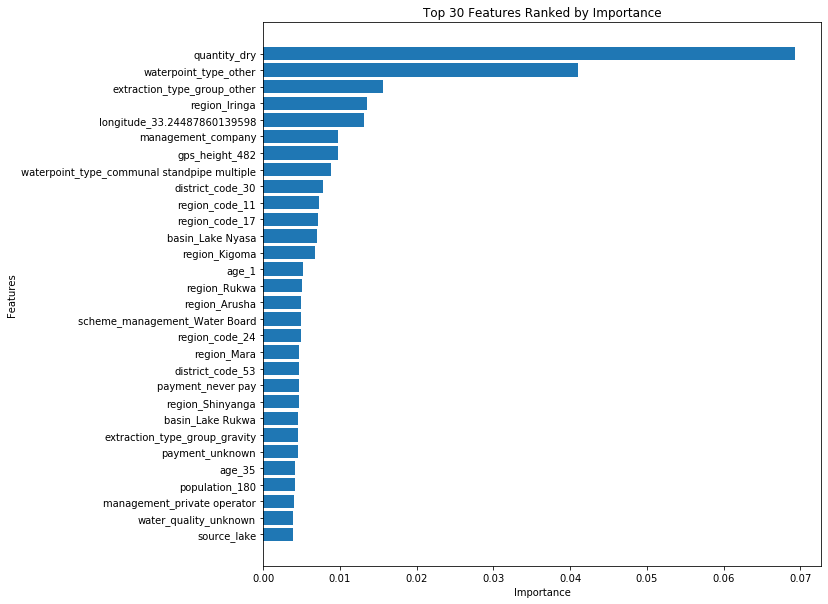

In [118]:
plot_feature_importance(best_model, ohe_val, X, num_features=30)

The most predictive feature was water point quantity value 'dry', which is rather obvious. The next most predictive is the value 'other' in both 'waterpoint_type' and 'extraction_type'. This could be due to incomplete data, or there are several variaties of well lumped into other that are of low quality. 'Region' shows up in many forms, indicating that either location or local managment ('Water Board' is region wide) for these areas contributes to well functionality.


#### Confusion Matrices, prediction stats:

Normalized Matrix:


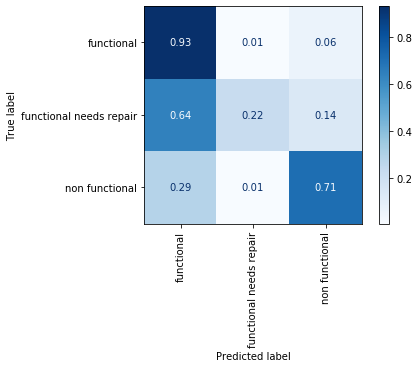

None

Quantity Matrix:


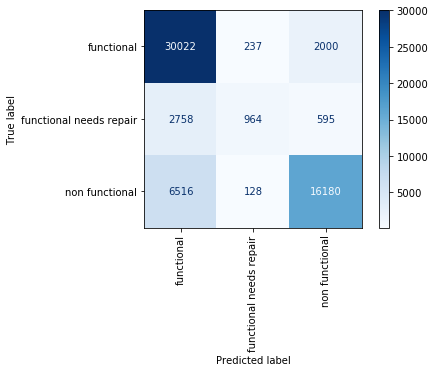

In [74]:
print('Normalized Matrix:')
display(plot_confusion(best_model, X_training_encoded, y, normalize='true'))
print('Quantity Matrix:')
plot_confusion(best_model, X_training_encoded, y, form='.0f')

The model is having difficultly discerning 'functional' from 'functional needs repair', 64% of 'fnr' are incorrectly classifed as 'functional'. I tried correcting the class imbalance but that didn't seem to improve performance.

## VALIDATION

In [79]:
# predict with X_val_preprocessed
y_pred_val = best_model.predict(X_validate_encoded)

# reformat to submission format csv, maintain 'id' columns
df_y_pred_val = pd.DataFrame(y_pred_val, index=X_validate.index, columns=['status_group'])

#check format and prediction rate
display(df_y_pred_val.head())
df_y_pred_val['status_group'].value_counts(normalize=True)

,status_group
id,
50785,functional
51630,functional
17168,functional
45559,non functional
49871,functional


functional                 0.661616
non functional             0.317980
functional needs repair    0.020404
Name: status_group, dtype: float64

In [80]:
# export to CSV, submit to score final model
df_y_pred_val.to_csv("../predictions/df_y_validation2.csv")

### Conclusion

The model scored 77.97% prediction accuracy on the validation set upon submission. The modeling test set scored 77.63%. Only 0.34% difference, indicating the model is fit well and not over trained. The model is having difficultly discerning 'functional' from 'functional needs repair', I tried correcting the class imbalance but that didn't seem to improve performance of the model overall, since there was significant overfitting.

<div>
<img src="../images/score.png" width="400"/>
</div>

### Future Work
A different strategy: Since correcting the imbalance for the rare class did not improve the model, perehaps explore model stacking. First binary between 'functional' and 'non' and then between between 'functional' and 'needs repair'. 

With more time: Further tuning of the models could be done to strengthen classification ability. Reworking or eliminating certain features from the data to provide a more distinct boundary for the model to learn from.

In [84]:
# #pickl models to avoid long runtimes if re-using
# f = open("../predictions/models.pkl", "wb")
# pickle.dump(best_xgbt, f)
# pickle.dump(xgbt, f)
# pickle.dump(base_gbt, f)
# pickle.dump(best_model, f)
# f.close()

In [6]:
# ## Copy/paste this to import the pickled dicts
# f = open("../predictions/models.pkl", 'rb')
# best_xgbt = pickle.load(f)
# xgbt = pickle.load(f)
# base_gbt = pickle.load(f)
# best_model= pickle.load(f)
# f.close()